In [2]:
import os
from pathlib import Path

# --- EDIT THESE ---
REPO_ROOT = Path("/sdf/data/rubin/user/mrakovci/Projects/Asteroid_detection_CNN").resolve()

# Your dataset products used in previous notebook:
CATALOG_PATH = Path("../DATA/test.csv")   # <-- edit
H5_PATH      = Path("../DATA/test.h5")        # <-- edit

# Butler repo / collections used by get_calexp_for_row in your previous notebook:
BUTLER_REPO = "/repo/main"                     # <-- edit if needed
COLLECTIONS = ["LSSTComCam/runs/DRP/DP1/w_2025_17/DM-50530"]                             # <-- edit if needed

# Sampling sizes (butler I/O is expensive)
N_SANITY = 500     # cheap: stack_snr checks (no butler needed)
N_MODEL  = 300     # expensive: sigmaF calls (butler needed)

print("REPO_ROOT:", REPO_ROOT)
print("CATALOG_PATH:", CATALOG_PATH)
print("H5_PATH:", H5_PATH)
print("BUTLER_REPO:", BUTLER_REPO)
print("COLLECTIONS:", COLLECTIONS)


REPO_ROOT: /sdf/data/rubin/user/mrakovci/Projects/Asteroid_detection_CNN
CATALOG_PATH: ../DATA/test.csv
H5_PATH: ../DATA/test.h5
BUTLER_REPO: /repo/main
COLLECTIONS: ['LSSTComCam/runs/DRP/DP1/w_2025_17/DM-50530']


In [3]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

# --- load catalog ---
if str(CATALOG_PATH).endswith(".parquet"):
    d = pd.read_parquet(CATALOG_PATH)
else:
    d = pd.read_csv(CATALOG_PATH)

print("Catalog rows:", len(d))
print("Columns:", list(d.columns)[:30], "...")

# --- load masks from H5 ---
with h5py.File(H5_PATH, "r") as f:
    # Adjust the key to whatever your file uses (examples: "masks", "mask", "y", etc.)
    # Print keys once to confirm.
    print("H5 keys:", list(f.keys()))
    # Common pattern:
    masks = f["masks"][:] if "masks" in f else f[list(f.keys())[0]][:]

print("masks shape:", masks.shape, "dtype:", masks.dtype)


Catalog rows: 1000
Columns: ['ra', 'dec', 'source_type', 'trail_length', 'mag', 'beta', 'visit', 'detector', 'integrated_mag', 'PSF_mag', 'SNR', 'physical_filter', 'x', 'y', 'stack_detection', 'stack_mag', 'stack_mag_err', 'stack_snr', 'image_id'] ...
H5 keys: ['images', 'masks', 'real_labels']
masks shape: (50, 4000, 4072) dtype: bool


In [4]:
import sys
sys.path.insert(0, str(REPO_ROOT))
sys.path.insert(0, str(REPO_ROOT / "ADCNN"))
sys.path.insert(0, "/sdf/data/rubin/user/mrakovci/Projects/Asteroid_detection_CNN/ADCNN/data/dataset_creation")

# Import your current implementation
from ADCNN.data.dataset_creation.common import psf_fit_flux_sigma, psf_fwhm_arcsec_from_calexp


In [9]:
from lsst.daf.butler import Butler

butler = Butler(BUTLER_REPO, collections=COLLECTIONS)

def get_calexp_for_row(row):
    visit = int(row["visit"])
    det   = int(row["detector"])
    calexp = butler.get("preliminary_visit_image", visit=visit, detector=det)
    return calexp


Rows used: 500
Median ratio stack_snr / (1.0857/magerr): nan


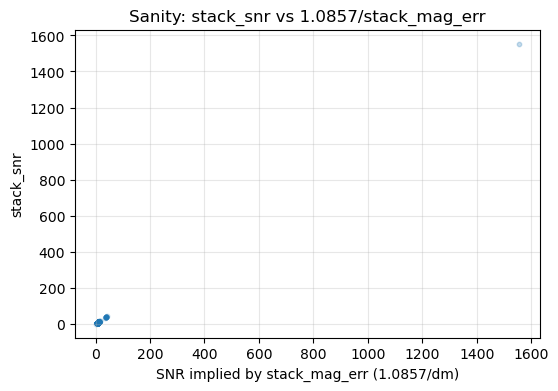

In [6]:
ss = d.sample(n=min(N_SANITY, len(d)), random_state=0).copy()

# adapt if your columns are slightly different
stack_snr = ss["stack_snr"].astype(float).to_numpy()
magerr    = ss["stack_mag_err"].astype(float).to_numpy()

snr_from_magerr = 1.0857 / magerr

ratio = stack_snr / snr_from_magerr
print("Rows used:", len(ss))
print("Median ratio stack_snr / (1.0857/magerr):", np.median(ratio))

plt.figure(figsize=(6,4))
plt.scatter(snr_from_magerr, stack_snr, s=10, alpha=0.25)
plt.xlabel("SNR implied by stack_mag_err (1.0857/dm)")
plt.ylabel("stack_snr")
plt.title("Sanity: stack_snr vs 1.0857/stack_mag_err")
plt.grid(True, alpha=0.3)
plt.show()


Used: 230 dropped: 70
Median ratio stack/snr_raw: 4.174971503009655
MAD ratio: 1.4417370123356428


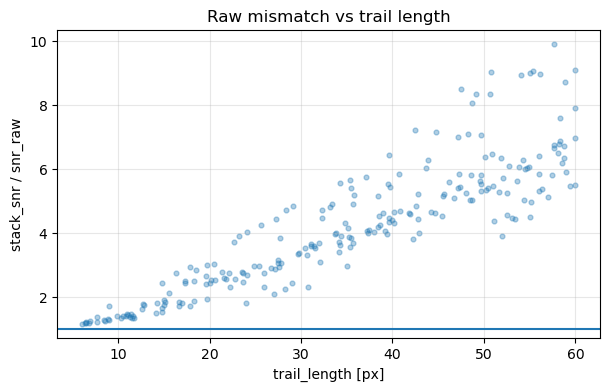

In [10]:
def model_snr_from_mag(calexp, mag, sigmaF):
    F = float(calexp.getPhotoCalib().magnitudeToInstFlux(float(mag)))
    return F / float(sigmaF)

ssm = d.sample(n=min(N_MODEL, len(d)), random_state=1).copy()

rows = []
bad = 0

for _, row in ssm.iterrows():
    try:
        calexp = get_calexp_for_row(row)

        x0 = float(row["x"]); y0 = float(row["y"])
        L  = float(row["trail_length"])
        th = float(row["beta"])

        # stack PSF magnitude proxy
        psf_mag = float(row["stack_mag"])
        stack_snr = float(row["stack_snr"])

        sigmaF = psf_fit_flux_sigma(
            calexp, x0, y0,
            L_pix=L, theta_deg=th,
            use_kernel_image=True,
            pad_sigma=5.0,
            step=0.15,
        )
        if not np.isfinite(sigmaF) or sigmaF <= 0:
            bad += 1
            continue

        snr_raw = model_snr_from_mag(calexp, psf_mag, sigmaF)
        if not np.isfinite(snr_raw) or snr_raw <= 0:
            bad += 1
            continue

        rows.append((L, stack_snr, snr_raw))
    except Exception as e:
        print (e)
        bad += 1
        continue

rows = np.asarray(rows, float)
print("Used:", len(rows), "dropped:", bad)

L = rows[:,0]
stack = rows[:,1]
snr_raw = rows[:,2]

ratio = stack / snr_raw
print("Median ratio stack/snr_raw:", np.median(ratio))
print("MAD ratio:", np.median(np.abs(ratio - np.median(ratio))))

plt.figure(figsize=(7,4))
plt.scatter(L, ratio, s=12, alpha=0.35)
plt.axhline(1.0)
plt.xlabel("trail_length [px]")
plt.ylabel("stack_snr / snr_raw")
plt.title("Raw mismatch vs trail length")
plt.grid(True, alpha=0.3)
plt.show()


Raw:   median(stack - snr_raw):  5.234423769092
Raw:   MAD(stack - snr_raw):     1.091102002101957
Corr:  median(stack - snr_corr): 0.02787971213992746
Corr:  MAD(stack - snr_corr):    0.6851499336799249


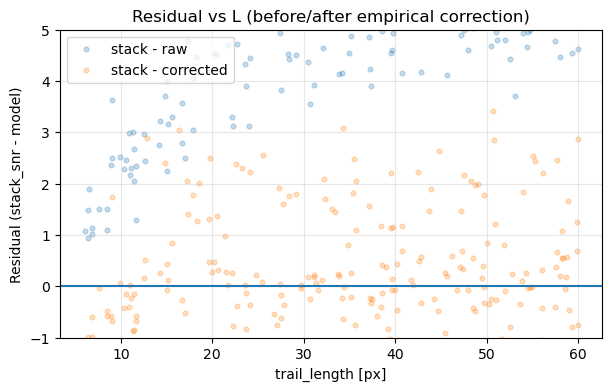

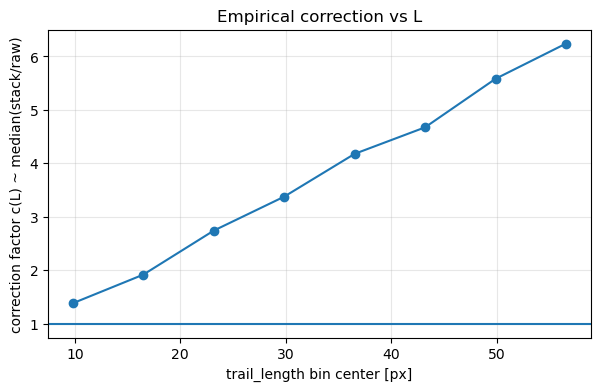

In [12]:
def binned_median(x, y, bins):
    x = np.asarray(x); y = np.asarray(y)
    out = []
    for i in range(len(bins)-1):
        m = (x >= bins[i]) & (x < bins[i+1]) & np.isfinite(y) & np.isfinite(x)
        if np.any(m):
            out.append(((bins[i]+bins[i+1])/2.0, np.median(y[m]), np.sum(m)))
    return np.asarray(out, float)

# correction factor c(L) such that: snr_corr = snr_raw * c(L)
# where c(L) ~ median(stack/snr_raw) in each bin
bins = np.linspace(np.percentile(L, 1), np.percentile(L, 99), 9)
bm = binned_median(L, ratio, bins)

bx = bm[:,0]
by = bm[:,1]

def c_of_L(Lval):
    Lval = np.asarray(Lval, float)
    return np.interp(Lval, bx, by, left=by[0], right=by[-1])

cL = c_of_L(L)
snr_corr = snr_raw * cL

res_raw  = stack - snr_raw
res_corr = stack - snr_corr

print("Raw:   median(stack - snr_raw): ", np.median(res_raw))
print("Raw:   MAD(stack - snr_raw):    ", np.median(np.abs(res_raw - np.median(res_raw))))
print("Corr:  median(stack - snr_corr):", np.median(res_corr))
print("Corr:  MAD(stack - snr_corr):   ", np.median(np.abs(res_corr - np.median(res_corr))))

plt.figure(figsize=(7,4))
plt.scatter(L, res_raw,  s=12, alpha=0.25, label="stack - raw")
plt.scatter(L, res_corr, s=12, alpha=0.25, label="stack - corrected")
plt.axhline(0.0)
plt.xlabel("trail_length [px]")
plt.ylabel("Residual (stack_snr - model)")
plt.ylim(-1,5)
plt.title("Residual vs L (before/after empirical correction)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(7,4))
plt.plot(bx, by, marker="o")
plt.axhline(1.0)
plt.xlabel("trail_length bin center [px]")
plt.ylabel("correction factor c(L) ~ median(stack/raw)")
plt.title("Empirical correction vs L")
plt.grid(True, alpha=0.3)
plt.show()


Used: 230 dropped: 70


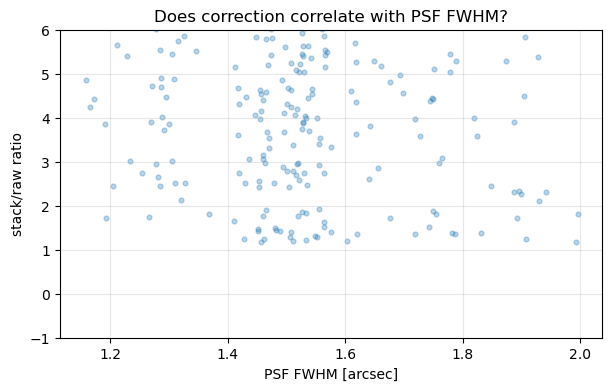

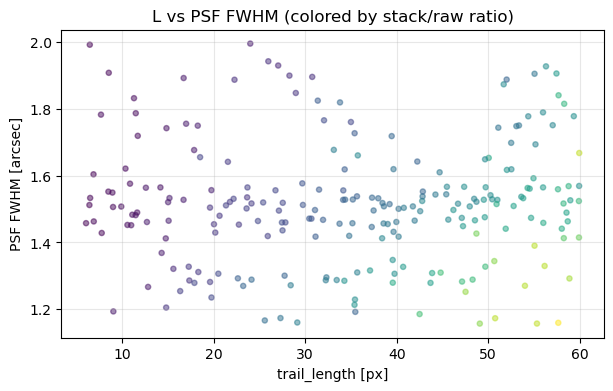

In [14]:
# Build a small table with (L, fwhm, ratio) and do coarse 2D binning
fwhms = []
for _, row in ssm.loc[ssm.index[:min(len(ssm), len(rows))]].iterrows():
    # This loop is only meaningful if you re-run sigmaF loop while also saving FWHM.
    pass

# Recommended approach: re-run the sigmaF loop once, but also compute FWHM:
rows2 = []
bad2 = 0
for _, row in ssm.iterrows():
    try:
        calexp = get_calexp_for_row(row)

        x0 = float(row["x"]); y0 = float(row["y"])
        L  = float(row["trail_length"])
        th = float(row["beta"])
        psf_mag = float(row["stack_mag"])
        stack_snr = float(row["stack_snr"])

        sigmaF = psf_fit_flux_sigma(calexp, x0, y0, L_pix=L, theta_deg=th,
                                    use_kernel_image=True, pad_sigma=5.0, step=0.15)
        if not np.isfinite(sigmaF) or sigmaF <= 0:
            bad2 += 1
            continue

        snr_raw = model_snr_from_mag(calexp, psf_mag, sigmaF)
        if not np.isfinite(snr_raw) or snr_raw <= 0:
            bad2 += 1
            continue

        fwhm = psf_fwhm_arcsec_from_calexp(calexp, x0, y0, use_kernel_image=True)
        if not np.isfinite(fwhm) or fwhm <= 0:
            bad2 += 1
            continue

        rows2.append((L, fwhm, stack_snr, snr_raw))
    except Exception:
        bad2 += 1
        continue

rows2 = np.asarray(rows2, float)
print("Used:", len(rows2), "dropped:", bad2)

L2 = rows2[:,0]
F2 = rows2[:,1]
stack2 = rows2[:,2]
raw2 = rows2[:,3]
ratio2 = stack2 / raw2

plt.figure(figsize=(7,4))
plt.scatter(F2, ratio2, s=12, alpha=0.3)
plt.xlabel("PSF FWHM [arcsec]")
plt.ylabel("stack/raw ratio")
plt.ylim(-1, 6)
plt.title("Does correction correlate with PSF FWHM?")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(7,4))
plt.scatter(L2, F2, c=ratio2, s=14, alpha=0.5)
plt.xlabel("trail_length [px]")
plt.ylabel("PSF FWHM [arcsec]")
plt.title("L vs PSF FWHM (colored by stack/raw ratio)")
plt.grid(True, alpha=0.3)
plt.show()
